<a href="https://colab.research.google.com/github/Shaggstar/Object-Myths/blob/main/Sim_V1_MOH_Intimates_%3EArchetypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a simulation that illustrates the myth of objectivity hypothesis (MOH), the claim that humanity's symbolic cogntive modeling ability is connected to morality and cultural identification. The original theory has been formalized as a unique treament of Active Inference, a framework that generalized the view of cognition as prediction modeling, where

The prior version illustrated the difference between

In [3]:
# -*- coding: utf-8 -*-
"""Extended MOH Simulation: From Intimate Models to Cultural Archetypes

This simulation extends the Myth of Objectivity Hypothesis (MOH) model to illustrate
the evolutionary transition from intimate to symbolic group coordination through:
1. High-dimensional emotional intimate models
2. Tag-based cooperation models
3. Binary moral type classification
4. Archetypal role-based coordination

It also examines scaling properties, network structures, and belief convergence patterns.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from matplotlib.animation import FuncAnimation
from scipy.stats import entropy
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Try to import pymdp for KL divergence calculation
try:
    from pymdp import utils
    pymdp_available = True
    print("PyMDP library available")
except ImportError:
    pymdp_available = False
    print("PyMDP library not available - using simplified calculations")

# Set random seed for reproducibility
np.random.seed(42)

PyMDP library not available - using simplified calculations


We're using NetworkX for social network visualization, TSNE for dimensionality reduction to visualize high-dimensional emotional states, and standard scientific computing libraries.
# 2 Paremeters and Functions

In [4]:
# Global simulation parameters
class SimParams:
    def __init__(self, group_size=100, iterations=200):
        # Core parameters
        self.group_size = group_size
        self.iterations = iterations
        self.cooperation_benefit = 2.0
        self.defection_cost = 1.0
        self.learning_rate = 0.05
        self.exploration_rate = 0.1

        # Cognitive limits for each model type
        self.cognitive_limits = {
            'intimate': 10,    # Intimate model: ~10 individuals
            'tag': 30,         # Tag-based model: ~30 individuals
            'moral': 100,      # Moral types: ~100 individuals
            'archetype': float('inf')  # Archetypal: unlimited
        }

        # Emotional state parameters
        self.emotion_dims = 5   # Dimensions of emotional state space
        self.num_tags = 5       # Number of possible tags
        self.num_archetypes = 7  # Number of archetypal roles

        # Contexts for archetypal roles (hunting, conflict, etc.)
        self.contexts = ['neutral', 'hunting', 'conflict', 'celebration', 'crisis']

        # Interaction parameters
        self.interactions_per_agent = {
            'intimate': 3,   # Intimate agents interact with fewer partners
            'tag': 4,        # Tag-based agents interact with more
            'moral': 5,      # Moral type agents interact with even more
            'archetype': 6   # Archetypal agents interact with the most
        }

# Helper functions for various calculations
def calculate_kl_divergence(dist1, dist2):
    """Calculate KL divergence between two distributions"""
    # Ensure valid probability distributions (avoid zeros)
    dist1 = np.clip(dist1, 0.01, 0.99)
    dist1 = dist1 / dist1.sum()

    dist2 = np.clip(dist2, 0.01, 0.99)
    dist2 = dist2 / dist2.sum()

    # Calculate KL divergence
    if pymdp_available:
        try:
            # Try to use pymdp's function if available
            return utils.kl_div(dist1, dist2)
        except:
            # Fall back to manual calculation
            return np.sum(dist1 * np.log(dist1 / dist2))
    else:
        # Manual calculation
        return np.sum(dist1 * np.log(dist1 / dist2))

def emotional_distance(emotion1, emotion2):
    """Calculate distance between two emotional states"""
    return np.linalg.norm(emotion1 - emotion2)

def create_social_network(agents, threshold=0.5):
    """Create a social network from agent interactions"""
    G = nx.Graph()

    # Add all agents as nodes
    for agent in agents:
        G.add_node(agent.id)

    # Add edges based on interaction history
    for agent in agents:
        for partner_id, strength in agent.get_relationships().items():
            if strength > threshold and partner_id in [a.id for a in agents]:
                G.add_edge(agent.id, partner_id, weight=strength)

    return G

Purpose: This section defines the core simulation parameters and helper functions. The SimParams class centralizes all simulation parameters, making it easy to adjust group sizes, cognitive limits, and other factors. The helper functions handle mathematical operations like KL divergence calculation, emotional distance measurement, and social network creation.
# 3: Agent Classes


## 3a: Intimate Agents

In [5]:
class EmotionalState:
    """Represents a multi-dimensional emotional state"""
    def __init__(self, dims=5):
        self.dims = dims
        # Initialize with random emotional values
        self.values = np.random.normal(0, 1, dims)
        # Normalize to unit length
        self.values = self.values / np.linalg.norm(self.values)

    def update(self, stimulus, learning_rate=0.1):
        """Update emotional state based on stimulus"""
        delta = stimulus - self.values
        self.values += learning_rate * delta
        # Re-normalize
        self.values = self.values / np.linalg.norm(self.values)

    def get_response(self, situation):
        """Generate a response based on emotional state and situation"""
        # Combine emotional state with situation to determine response
        combined = self.values + 0.5 * situation
        # Discretize to binary response for simplicity
        return 1 if np.mean(combined) > 0 else 0

class IntimateAgent:
    """Agent using high-dimensional emotional models of known individuals"""
    def __init__(self, agent_id, params):
        self.id = agent_id
        self.params = params
        # Own emotional state
        self.emotional_state = EmotionalState(params.emotion_dims)
        # Models of other agents' emotional states
        self.known_agents = {}  # {agent_id: EmotionalState}
        self.interaction_counts = {}  # {agent_id: count}
        self.fitness = 0
        self.interactions = []
        self.cooperation_history = []

    def decide_action(self, partner_id, context=None):
        # Random exploration
        if np.random.random() < self.params.exploration_rate:
            return np.random.choice([0, 1])

        # Create situational context vector
        situation = np.random.normal(0, 1, self.params.emotion_dims)

        # If partner is known, use emotional model to predict their behavior
        if partner_id in self.known_agents:
            # Predict partner's response based on our model of them
            return self.known_agents[partner_id].get_response(situation)

        # Default to defection with unknown partners
        return 0

    def update_beliefs(self, partner_id, partner_action, partner_emotional_state=None):
        # Track interaction
        if partner_id not in self.interaction_counts:
            self.interaction_counts[partner_id] = 0
        self.interaction_counts[partner_id] += 1

        # If this is a new partner, initialize model
        if partner_id not in self.known_agents:
            if partner_emotional_state is not None:
                # Copy the actual emotional state if provided (for simulation purposes)
                self.known_agents[partner_id] = EmotionalState(self.params.emotion_dims)
                self.known_agents[partner_id].values = partner_emotional_state.values.copy()
            else:
                # Initialize with a random model
                self.known_agents[partner_id] = EmotionalState(self.params.emotion_dims)

        # Update emotional model based on observed action
        situation = np.random.normal(0, 1, self.params.emotion_dims)
        predicted_action = self.known_agents[partner_id].get_response(situation)

        # If prediction was wrong, update model
        if predicted_action != partner_action:
            # Adjust emotional model to better predict this action
            adjustment = (partner_action - 0.5) * np.random.normal(0, 1, self.params.emotion_dims)
            self.known_agents[partner_id].update(adjustment, self.params.learning_rate)

        # If known agents exceed cognitive capacity, forget the least frequently encountered
        if len(self.known_agents) > self.params.cognitive_limits['intimate']:
            min_agent = min(self.interaction_counts, key=self.interaction_counts.get)
            del self.known_agents[min_agent]
            del self.interaction_counts[min_agent]

    def update_fitness(self, my_action, partner_action):
        # Calculate payoff
        payoff = 0
        if my_action == 1:  # I cooperated
            payoff -= 1  # Base cost of cooperation
            if partner_action == 1:  # Partner cooperated
                payoff += self.params.cooperation_benefit
        if partner_action == 0:  # Partner defected
            payoff -= self.params.defection_cost

        self.fitness += payoff
        self.cooperation_history.append(my_action)

    def get_relationships(self):
        """Return dictionary of relationship strengths"""
        return {agent_id: count/max(self.interaction_counts.values())
                for agent_id, count in self.interaction_counts.items()}

    def get_computational_load(self):
        """Return agent's computational load"""
        return len(self.known_agents) * self.params.emotion_dims

## 3b. Tag Signal

```
`# This is formatted as code`
```



In [6]:
class TagAgent:
    """Agent using tag-based models for categorizing others"""
    def __init__(self, agent_id, params):
        self.id = agent_id
        self.params = params
        self.tag = np.random.randint(0, params.num_tags)  # Assigned tag
        # Beliefs about cooperation likelihood for each tag
        self.tag_beliefs = {t: 0.5 for t in range(params.num_tags)}
        # Strength of identification with own tag (0-1)
        self.tag_identification = np.random.beta(2, 2)
        self.fitness = 0
        self.interactions = []
        self.cooperation_history = []
        # Track tag distances
        self.tag_distances = np.zeros(params.num_tags)

    def decide_action(self, partner_tag):
        # Random exploration
        if np.random.random() < self.params.exploration_rate:
            return np.random.choice([0, 1])

        # Calculate tag similarity (0 = same tag, higher = more different)
        tag_distance = min(abs(self.tag - partner_tag),
                           self.params.num_tags - abs(self.tag - partner_tag))
        normalized_distance = tag_distance / (self.params.num_tags / 2)

        # Weight decision by tag similarity and cooperation belief
        similarity_weight = 1 - normalized_distance
        coop_probability = (similarity_weight * self.tag_identification +
                           (1 - similarity_weight) * self.tag_beliefs[partner_tag])

        return 1 if np.random.random() < coop_probability else 0

    def update_beliefs(self, partner_tag, partner_action):
        # Update beliefs about this tag using prediction error
        prediction_error = partner_action - self.tag_beliefs[partner_tag]
        self.tag_beliefs[partner_tag] += self.params.learning_rate * prediction_error

        # Track tag distance
        tag_distance = min(abs(self.tag - partner_tag),
                           self.params.num_tags - abs(self.tag - partner_tag))
        self.tag_distances[partner_tag] += 1

    def update_fitness(self, my_action, partner_action):
        # Calculate payoff
        payoff = 0
        if my_action == 1:  # I cooperated
            payoff -= 1  # Base cost of cooperation
            if partner_action == 1:  # Partner cooperated
                payoff += self.params.cooperation_benefit
        if partner_action == 0:  # Partner defected
            payoff -= self.params.defection_cost

        self.fitness += payoff
        self.cooperation_history.append(my_action)

    def get_relationships(self):
        """Return dictionary of relationship strengths based on tag beliefs"""
        relationships = {}
        for agent_id in range(self.params.group_size):
            if agent_id != self.id:
                other_tag = agent_id % self.params.num_tags  # Deterministic tag assignment for this function
                relationships[agent_id] = self.tag_beliefs[other_tag]
        return relationships

    def get_computational_load(self):
        """Return agent's computational load"""
        return self.params.num_tags  # One value per tag

## 3c: Moral Typing

In [7]:
class MoralAgent:
    """Agent using binary moral types to classify others"""
    def __init__(self, agent_id, params):
        self.id = agent_id
        self.params = params
        self.tag = np.random.randint(0, params.num_tags)  # Underlying tag (not directly observed)

        # Moral assessment of others - binary in-group/out-group classification
        self.moral_types = {}  # {agent_id: binary classification}

        # Personal model of cooperation
        self.personal_model = 0.5

        # Cultural belief about general cooperation level
        self.cultural_belief = 0.5

        # How much agent adheres to cultural norms (0-1)
        self.norm_adherence = np.random.beta(5, 2)

        # Track interactions and fitness
        self.fitness = 0
        self.interactions = []
        self.cooperation_history = []

        # Track which agents are assessed
        self.assessed_agents = set()

    def assess_moral_type(self, agent_id, agent_behavior=None):
        """Classify another agent as in-group (1) or out-group (0)"""
        if agent_id in self.moral_types:
            return self.moral_types[agent_id]

        # If behavior is provided, use it for assessment
        if agent_behavior is not None:
            # Agents who cooperate are more likely to be classified as in-group
            if agent_behavior == 1:  # Cooperation
                moral_type = 1 if np.random.random() < 0.8 else 0
            else:  # Defection
                moral_type = 0 if np.random.random() < 0.8 else 1
        else:
            # Default to out-group for unknown agents
            moral_type = 0

        self.moral_types[agent_id] = moral_type
        self.assessed_agents.add(agent_id)
        return moral_type

    def decide_action(self, partner_id, partner_tag=None):
        # Random exploration
        if np.random.random() < self.params.exploration_rate:
            return np.random.choice([0, 1])

        # Assess partner's moral type if not already done
        if partner_id not in self.moral_types:
            # For simulation, we use tag similarity as proxy for initial assessment
            if partner_tag is not None:
                tag_distance = min(abs(self.tag - partner_tag),
                                  self.params.num_tags - abs(self.tag - partner_tag))
                initial_impression = 1 if tag_distance <= 1 else 0  # In-group if similar tag
            else:
                initial_impression = 0
            self.assess_moral_type(partner_id, initial_impression)

        # Decision combines cultural norms with personal model and moral classification
        if self.moral_types[partner_id] == 1:  # In-group
            # Higher chance of cooperation with in-group
            personal_weight = 1 - self.norm_adherence
            cultural_weight = self.norm_adherence

            cooperation_prob = (personal_weight * self.personal_model +
                              cultural_weight * self.cultural_belief)
        else:  # Out-group
            # Very low chance of cooperation with out-group
            cooperation_prob = 0.1

        return 1 if np.random.random() < cooperation_prob else 0

    def update_beliefs(self, partner_id, partner_action, observed_actions=None):
        # Update moral assessment based on partner's action
        if partner_id in self.moral_types:
            # If partner defected but was classified as in-group, re-evaluate
            if partner_action == 0 and self.moral_types[partner_id] == 1:
                if np.random.random() < 0.3:  # 30% chance of reclassification
                    self.moral_types[partner_id] = 0

            # If partner cooperated but was classified as out-group, re-evaluate
            elif partner_action == 1 and self.moral_types[partner_id] == 0:
                if np.random.random() < 0.3:  # 30% chance of reclassification
                    self.moral_types[partner_id] = 1

        # Update cultural belief if observed actions provided
        if observed_actions is not None:
            cultural_error = np.mean(observed_actions) - self.cultural_belief
            self.cultural_belief += self.params.learning_rate * cultural_error

        # Update personal model based on recent experiences
        if len(self.interactions) > 0:
            recent_outcomes = [action for _, action in self.interactions[-10:]]
            if recent_outcomes:
                personal_error = np.mean(recent_outcomes) - self.personal_model
                self.personal_model += self.params.learning_rate * 2 * personal_error

    def update_fitness(self, my_action, partner_action):
        # Calculate payoff
        payoff = 0
        if my_action == 1:  # I cooperated
            payoff -= 1  # Base cost of cooperation
            if partner_action == 1:  # Partner cooperated
                payoff += self.params.cooperation_benefit
        if partner_action == 0:  # Partner defected
            payoff -= self.params.defection_cost

        self.fitness += payoff

        # Record interaction
        self.interactions.append((partner_action, my_action))
        if len(self.interactions) > 100:
            self.interactions.pop(0)

        self.cooperation_history.append(my_action)

    def get_relationships(self):
        """Return dictionary of relationship strengths based on moral classification"""
        return {agent_id: 1.0 if type == 1 else 0.0
                for agent_id, type in self.moral_types.items()}

    def get_computational_load(self):
        """Return agent's computational load"""
        return len(self.moral_types)  # One bit per assessed agent

## 3d: Archetyping  

In [8]:
class ArchetypalAgent:
    """Agent using archetypal roles for flexible social coordination"""
    def __init__(self, agent_id, params):
        self.id = agent_id
        self.params = params
        self.tag = np.random.randint(0, params.num_tags)  # Underlying tag

        # Cultural belief about general cooperation level
        self.cultural_belief = 0.5

        # Personal model of cooperation
        self.personal_model = 0.5

        # How much agent adheres to cultural norms (0-1)
        self.norm_adherence = np.random.beta(5, 2)

        # Agent's archetype affinities (how well they fit each archetype)
        self.archetype_affinities = np.random.dirichlet(
            np.ones(params.num_archetypes))

        # Agent's perception of others' archetypes
        self.perceived_archetypes = {}  # {agent_id: archetype_distribution}

        # Archetypal cooperation matrices for different contexts
        # [context][my_archetype][their_archetype] = cooperation_probability
        self.archetype_cooperation = self._initialize_archetype_cooperation()

        # Fitness and interaction tracking
        self.fitness = 0
        self.interactions = []
        self.cooperation_history = []
        self.cmd_history = []  # Track conceptual model divergence

    def _initialize_archetype_cooperation(self):
        """Initialize archetypal cooperation matrices for different contexts"""
        cooperation_matrices = {}

        # Define classic archetypal roles
        archetypes = ['leader', 'nurturer', 'warrior', 'trickster',
                     'sage', 'creator', 'explorer']

        # For each context, define a cooperation matrix between archetypes
        for context in self.params.contexts:
            matrix = np.zeros((self.params.num_archetypes, self.params.num_archetypes))

            if context == 'neutral':
                # Default: moderate cooperation within similar archetypes
                for i in range(self.params.num_archetypes):
                    for j in range(self.params.num_archetypes):
                        similarity = 1 - abs(i-j)/self.params.num_archetypes
                        matrix[i,j] = 0.3 + 0.4 * similarity

            elif context == 'hunting':
                # Hunting: leader-warrior-explorer synergy
                matrix[0,:] = 0.7  # Leaders cooperate with all
                matrix[:,0] = 0.7  # All cooperate with leaders
                matrix[2,6] = 0.9  # Warriors cooperate with explorers
                matrix[6,2] = 0.9  # Explorers cooperate with warriors

            elif context == 'conflict':
                # Conflict: warriors lead, tricksters support
                matrix[2,:] = 0.8  # Warriors cooperate with all
                matrix[:,2] = 0.8  # All cooperate with warriors
                matrix[3,2] = 0.9  # Tricksters specially support warriors

            elif context == 'celebration':
                # Celebration: generally high cooperation
                matrix[:,:] = 0.7
                matrix[5,:] = 0.9  # Creators especially cooperative

            elif context == 'crisis':
                # Crisis: sage-nurturer leadership
                matrix[4,:] = 0.8  # Sages cooperate with all
                matrix[:,4] = 0.8  # All cooperate with sages
                matrix[1,:] = 0.8  # Nurturers cooperate with all
                matrix[:,1] = 0.8  # All cooperate with nurturers

            # Ensure reasonable values
            matrix = np.clip(matrix, 0.2, 0.9)
            cooperation_matrices[context] = matrix

        return cooperation_matrices

    def assess_archetype(self, agent_id, agent_behavior=None, context=None):
        """Determine perceived archetypal role of another agent"""
        if agent_id in self.perceived_archetypes:
            # Already have assessment for this agent
            return self.perceived_archetypes[agent_id]

        # Initial assessment based on observed behavior if provided
        if agent_behavior is not None and context is not None:
            # Different contexts favor different archetypes for cooperative behavior
            if agent_behavior == 1:  # Cooperation
                if context == 'hunting':
                    primary_archetypes = [0, 2, 6]  # Leader, warrior, explorer
                elif context == 'conflict':
                    primary_archetypes = [0, 2, 3]  # Leader, warrior, trickster
                elif context == 'celebration':
                    primary_archetypes = [1, 5]     # Nurturer, creator
                elif context == 'crisis':
                    primary_archetypes = [1, 4]     # Nurturer, sage
                else:
                    primary_archetypes = range(self.params.num_archetypes)

                # Bias toward context-appropriate archetypes
                distribution = np.ones(self.params.num_archetypes) * 0.5
                for arch in primary_archetypes:
                    distribution[arch] = 2.0
            else:
                # Defection - less clear archetypal signal
                distribution = np.ones(self.params.num_archetypes)
        else:
            # Random initial assessment
            distribution = np.ones(self.params.num_archetypes)

        # Convert to probability distribution
        distribution = distribution / distribution.sum()

        # Add random noise
        distribution = distribution + np.random.normal(0, 0.1, size=self.params.num_archetypes)
        distribution = np.clip(distribution, 0.01, None)
        distribution = distribution / distribution.sum()

        self.perceived_archetypes[agent_id] = distribution
        return distribution

    def decide_action(self, partner_id, context='neutral'):
        # Random exploration
        if np.random.random() < self.params.exploration_rate:
            return np.random.choice([0, 1])

        # Get archetype perception of partner
        if partner_id not in self.perceived_archetypes:
            self.assess_archetype(partner_id)
        partner_archetypes = self.perceived_archetypes[partner_id]

        # Calculate cooperation probability based on archetypal interaction matrix
        matrix = self.archetype_cooperation[context]

        # Weighted sum over all archetype combinations
        cooperation_prob = 0
        for my_arch in range(self.params.num_archetypes):
            for their_arch in range(self.params.num_archetypes):
                cooperation_prob += (self.archetype_affinities[my_arch] *
                                   partner_archetypes[their_arch] *
                                   matrix[my_arch, their_arch])

        # Blend with cultural belief according to norm adherence
        cooperation_prob = ((1 - self.norm_adherence) * cooperation_prob +
                          self.norm_adherence * self.cultural_belief)

        return 1 if np.random.random() < cooperation_prob else 0

    def update_beliefs(self, partner_id, partner_action, context='neutral', observed_actions=None):
        # Update archetypal assessment of partner
        if partner_id in self.perceived_archetypes:
            # Get current assessment
            current = self.perceived_archetypes[partner_id]

            # Determine which archetypes would have been more likely to take this action
            if partner_action == 1:  # Cooperation
                # Identify archetypes that tend to cooperate in this context
                cooperative_archetypes = np.mean(self.archetype_cooperation[context], axis=0)
            else:  # Defection
                # Inverse - archetypes less likely to cooperate
                cooperative_archetypes = 1 - np.mean(self.archetype_cooperation[context], axis=0)

            # Adjust current assessment toward these archetypes
            adjustment = self.params.learning_rate * (cooperative_archetypes - current)
            updated = current + adjustment

            # Normalize
            updated = np.clip(updated, 0.01, None)
            updated = updated / updated.sum()

            self.perceived_archetypes[partner_id] = updated

        # Update cultural belief if observed actions provided
        if observed_actions is not None:
            cultural_error = np.mean(observed_actions) - self.cultural_belief
            self.cultural_belief += self.params.learning_rate * cultural_error

        # Update personal model based on recent experiences
        if len(self.interactions) > 0:
            recent_outcomes = [action for _, action in self.interactions[-10:]]
            if recent_outcomes:
                personal_error = np.mean(recent_outcomes) - self.personal_model
                self.personal_model += self.params.learning_rate * 2 * personal_error

        # Calculate and track conceptual model divergence
        if observed_actions is not None and len(observed_actions) > 0:
            personal_dist = np.array([1-self.personal_model, self.personal_model])
            cultural_dist = np.array([1-self.cultural_belief, self.cultural_belief])
            cmd = calculate_kl_divergence(personal_dist, cultural_dist)
            self.cmd_history.append(cmd)

    def update_fitness(self, my_action, partner_action):
        # Calculate payoff
        payoff = 0
        if my_action == 1:  # I cooperated
            payoff -= 1  # Base cost of cooperation
            if partner_action == 1:  # Partner cooperated
                payoff += self.params.cooperation_benefit
        if partner_action == 0:  # Partner defected
            payoff -= self.params.defection_cost

        self.fitness += payoff

        # Record interaction
        self.interactions.append((partner_action, my_action))
        if len(self.interactions) > 100:
            self.interactions.pop(0)

        self.cooperation_history.append(my_action)

    def get_relationships(self):
        """Return dictionary of relationship strengths based on archetypal alignment"""
        relationships = {}
        for agent_id, archetypes in self.perceived_archetypes.items():
            # Calculate archetype compatibility
            compatibility = np.sum(self.archetype_affinities * archetypes)
            relationships[agent_id] = compatibility
        return relationships

    def get_computational_load(self):
        """Return agent's computational load"""
        # One vector per known agent plus context matrices
        return (len(self.perceived_archetypes) * self.params.num_archetypes +
                len(self.params.contexts) * self.params.num_archetypes**2)

This section defines the four types of agent models, each representing a different evolutionary stage of social coordination:

1. IntimateAgent: Uses high-dimensional emotional models of individuals, requiring significant cognitive resources to track each relationship separately.
2. TagAgent: Uses tags (markers) to categorize individuals and extend trust based on similarity, reducing cognitive load.
3. MoralAgent: Implements binary moral classification (in-group/out-group), further simplifying social coordination through categorical thinking.
4. ArchetypalAgent: Uses flexible archetypal roles that can be activated in different contexts, enabling complex coordination while maintaining cognitive efficiency.

Each agent type has methods for decision-making, belief updating, fitness tracking, and relationship management, with increasing sophistication in how they model and respond to social interactions.

# 4: Simulation Framework

In [9]:
class MOHSimulation:
    """Framework for running simulations of different social coordination models"""
    def __init__(self, params=None):
        # Use default parameters if none provided
        self.params = params if params is not None else SimParams()

        # Initialize storage for results
        self.reset_results()

    def reset_results(self):
        """Reset result storage"""
        self.results = {
            'intimate': {
                'avg_fitness': [], 'cooperation_rate': [],
                'computational_load': [], 'network': []
            },
            'tag': {
                'avg_fitness': [], 'cooperation_rate': [],
                'computational_load': [], 'network': []
            },
            'moral': {
                'avg_fitness': [], 'cooperation_rate': [],
                'computational_load': [], 'network': [], 'cmd': []
            },
            'archetype': {
                'avg_fitness': [], 'cooperation_rate': [],
                'computational_load': [], 'network': [], 'cmd': []
                }
        }

        # Store agent instances
        self.agents = {
            'intimate': [],
            'tag': [],
            'moral': [],
            'archetype': []
        }

        # Individual trajectories for representative agents
        self.tracked_agents = {
            'intimate': None,
            'tag': None,
            'moral': None,
            'archetype': None
        }
        self.tracked_data = {
            'intimate': {'fitness': [], 'coop_rate': [], 'models': []},
            'tag': {'fitness': [], 'coop_rate': [], 'models': []},
            'moral': {'fitness': [], 'coop_rate': [], 'models': [], 'cmd': []},
            'archetype': {'fitness': [], 'coop_rate': [], 'models': [], 'cmd': []}
        }

    def initialize_agents(self):
        """Create agent populations for each model type"""
        self.agents['intimate'] = [IntimateAgent(i, self.params)
                                  for i in range(self.params.group_size)]
        self.agents['tag'] = [TagAgent(i, self.params)
                             for i in range(self.params.group_size)]
        self.agents['moral'] = [MoralAgent(i, self.params)
                               for i in range(self.params.group_size)]
        self.agents['archetype'] = [ArchetypalAgent(i, self.params)
                                   for i in range(self.params.group_size)]

        # Select representative agents to track
        for model_type in self.agents:
            self.tracked_agents[model_type] = self.agents[model_type][0]

    def run_iteration(self, model_type, iteration):
        """Run a single iteration for a specific model type"""
        agents = self.agents[model_type]
        interactions = 0
        cooperations = 0
        all_actions = []

        # Determine number of interactions per agent
        interactions_per_agent = self.params.interactions_per_agent[model_type]

        # Randomly select context for this iteration (for archetypal agents)
        context = np.random.choice(self.params.contexts)

        # Each agent interacts with random partners
        for agent1_idx in range(len(agents)):
            # Select random partners that aren't self
            potential_partners = [i for i in range(len(agents)) if i != agent1_idx]
            if len(potential_partners) > 0:
                partner_indices = np.random.choice(
                    potential_partners,
                    size=min(interactions_per_agent, len(potential_partners)),
                    replace=False
                )

                for agent2_idx in partner_indices:
                    agent1 = agents[agent1_idx]
                    agent2 = agents[agent2_idx]

                    # Decision process depends on agent type
                    if model_type == 'intimate':
                        # Intimate agents decide based on individual models
                        action1 = agent1.decide_action(agent2.id)
                        action2 = agent2.decide_action(agent1.id)

                        # Update beliefs
                        agent1.update_beliefs(agent2.id, action2, agent2.emotional_state)
                        agent2.update_beliefs(agent1.id, action1, agent1.emotional_state)

                    elif model_type == 'tag':
                        # Tag agents decide based on tag similarity
                        action1 = agent1.decide_action(agent2.tag)
                        action2 = agent2.decide_action(agent1.tag)

                        # Update beliefs
                        agent1.update_beliefs(agent2.tag, action2)
                        agent2.update_beliefs(agent1.tag, action1)

                    elif model_type == 'moral':
                        # Moral agents decide based on binary classification
                        action1 = agent1.decide_action(agent2.id, agent2.tag)
                        action2 = agent2.decide_action(agent1.id, agent1.tag)

                        # Update beliefs individually
                        agent1.update_beliefs(agent2.id, action2)
                        agent2.update_beliefs(agent1.id, action1)

                    elif model_type == 'archetype':
                        # Archetypal agents use role-based decisions in context
                        action1 = agent1.decide_action(agent2.id, context)
                        action2 = agent2.decide_action(agent1.id, context)

                        # Update beliefs individually
                        agent1.update_beliefs(agent2.id, action2, context)
                        agent2.update_beliefs(agent1.id, action1, context)

                    # Update fitness for both agents
                    agent1.update_fitness(action1, action2)
                    agent2.update_fitness(action2, action1)

                    # Track cooperation
                    interactions += 2
                    cooperations += action1 + action2
                    all_actions.extend([action1, action2])

        # For moral and archetypal models, update cultural beliefs based on observed actions
        if model_type in ['moral', 'archetype'] and all_actions:
            for agent in agents:
                if hasattr(agent, 'update_beliefs') and 'observed_actions' in agent.update_beliefs.__code__.co_varnames:
                    agent.update_beliefs(None, None, observed_actions=all_actions)

        # Calculate metrics
        avg_fitness = np.mean([agent.fitness for agent in agents])
        coop_rate = cooperations / max(1, interactions)
        comp_load = np.mean([agent.get_computational_load() for agent in agents])

        # Store results
        self.results[model_type]['avg_fitness'].append(avg_fitness)
        self.results[model_type]['cooperation_rate'].append(coop_rate)
        self.results[model_type]['computational_load'].append(comp_load)

        # Calculate social network every 10 iterations (to save computation)
        if iteration % 10 == 0:
            self.results[model_type]['network'].append(
                create_social_network(agents)
            )

        # For moral and archetypal models, track CMD
        if model_type in ['moral', 'archetype']:
            if all_actions:
                cultural_rate = np.mean(all_actions)
                if model_type == 'moral':
                    avg_cmd = np.mean([
                        calculate_kl_divergence(
                            np.array([1-agent.personal_model, agent.personal_model]),
                            np.array([1-cultural_rate, cultural_rate])
                        ) for agent in agents
                    ])
                    self.results[model_type]['cmd'].append(avg_cmd)
                elif model_type == 'archetype' and hasattr(agents[0], 'cmd_history') and agents[0].cmd_history:
                    avg_cmd = np.mean([agent.cmd_history[-1] for agent in agents if agent.cmd_history])
                    self.results[model_type]['cmd'].append(avg_cmd)

        # Track representative agent data
        for model_type, agent in self.tracked_agents.items():
            # Skip if not initialized
            if agent is None:
                continue

            # Track fitness
            self.tracked_data[model_type]['fitness'].append(agent.fitness)

            # Track cooperation rate (rolling window)
            if hasattr(agent, 'cooperation_history') and agent.cooperation_history:
                window = min(10, len(agent.cooperation_history))
                recent_coop_rate = np.mean(agent.cooperation_history[-window:])
                self.tracked_data[model_type]['coop_rate'].append(recent_coop_rate)

            # Track model evolution (type-specific)
            if model_type == 'intimate' and hasattr(agent, 'known_agents'):
                # Track number of models
                self.tracked_data[model_type]['models'].append(len(agent.known_agents))
            elif model_type == 'tag' and hasattr(agent, 'tag_beliefs'):
                # Track belief distribution
                self.tracked_data[model_type]['models'].append(
                    list(agent.tag_beliefs.values())
                )
            elif model_type == 'moral' and hasattr(agent, 'moral_types'):
                # Track in-group percentage
                if agent.moral_types:
                    in_group_pct = sum(agent.moral_types.values()) / max(1, len(agent.moral_types))
                    self.tracked_data[model_type]['models'].append(in_group_pct)

                # Track CMD
                if hasattr(agent, 'personal_model') and hasattr(agent, 'cultural_belief'):
                    cmd = calculate_kl_divergence(
                        np.array([1-agent.personal_model, agent.personal_model]),
                        np.array([1-agent.cultural_belief, agent.cultural_belief])
                    )
                    self.tracked_data[model_type]['cmd'].append(cmd)
            elif model_type == 'archetype':
                # Track archetypal beliefs
                if hasattr(agent, 'perceived_archetypes') and agent.perceived_archetypes:
                    # Average archetype distribution across known agents
                    avg_dist = np.mean(list(agent.perceived_archetypes.values()), axis=0)
                    self.tracked_data[model_type]['models'].append(avg_dist)

                # Track CMD
                if hasattr(agent, 'cmd_history') and agent.cmd_history:
                    self.tracked_data[model_type]['cmd'].append(agent.cmd_history[-1])

    def run_simulation(self):
        """Run the full simulation for all model types"""
        print("Initializing agents...")
        self.initialize_agents()

        print(f"Running {self.params.iterations} iterations...")
        for iteration in range(self.params.iterations):
            if iteration % 10 == 0:
                print(f"Iteration {iteration}...")

            # Run iteration for each model type
            for model_type in self.agents:
                self.run_iteration(model_type, iteration)

        print("Simulation complete.")
        return self.results

This section defines the main simulation framework that orchestrates the interactions between agents. The MOHSimulation class handles agent initialization, running iterations, and collecting results. It provides methods to track fitness, cooperation rates, computational load, social networks, and conceptual model divergence for each model type. The framework also follows representative agents to track individual trajectories.
# 5: Group Size Scaling and Visualization

In [10]:
def run_group_size_scaling(group_sizes=[20, 50, 100, 200, 500], iterations=100):
    """Run simulations with different group sizes to examine scaling properties"""
    print("Running group size scaling experiments...")

    # Store results for each group size
    scaling_results = {
        'group_size': [],
        'intimate': {'fitness': [], 'coop_rate': [], 'comp_load': []},
        'tag': {'fitness': [], 'coop_rate': [], 'comp_load': []},
        'moral': {'fitness': [], 'coop_rate': [], 'comp_load': []},
        'archetype': {'fitness': [], 'coop_rate': [], 'comp_load': []}
    }

    # Run simulation for each group size
    for size in group_sizes:
        print(f"Testing group size: {size}")
        params = SimParams(group_size=size, iterations=iterations)
        sim = MOHSimulation(params)
        results = sim.run_simulation()

        # Store final values
        scaling_results['group_size'].append(size)

        for model_type in ['intimate', 'tag', 'moral', 'archetype']:
            # Use the average of last 10 iterations for stable measurements
            final_fitness = np.mean(results[model_type]['avg_fitness'][-10:])
            final_coop = np.mean(results[model_type]['cooperation_rate'][-10:])
            final_load = np.mean(results[model_type]['computational_load'][-10:])

            scaling_results[model_type]['fitness'].append(final_fitness)
            scaling_results[model_type]['coop_rate'].append(final_coop)
            scaling_results[model_type]['comp_load'].append(final_load)

    return scaling_results

def visualize_scaling_results(scaling_results):
    """Create visualizations of scaling experiment results"""
    group_sizes = scaling_results['group_size']

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Fitness scaling
    for model_type in ['intimate', 'tag', 'moral', 'archetype']:
        axes[0].plot(group_sizes, scaling_results[model_type]['fitness'],
                    marker='o', label=f"{model_type.capitalize()} Model")
    axes[0].set_xlabel('Group Size')
    axes[0].set_ylabel('Average Fitness')
    axes[0].set_title('Fitness Scaling with Group Size')
    axes[0].legend()

    # Cooperation rate scaling
    for model_type in ['intimate', 'tag', 'moral', 'archetype']:
        axes[1].plot(group_sizes, scaling_results[model_type]['coop_rate'],
                    marker='o', label=f"{model_type.capitalize()} Model")
    axes[1].set_xlabel('Group Size')
    axes[1].set_ylabel('Cooperation Rate')
    axes[1].set_title('Cooperation Rate Scaling with Group Size')
    axes[1].legend()

    # Computational load scaling
    for model_type in ['intimate', 'tag', 'moral', 'archetype']:
        axes[2].plot(group_sizes, scaling_results[model_type]['comp_load'],
                    marker='o', label=f"{model_type.capitalize()} Model")
    axes[2].set_xlabel('Group Size')
    axes[2].set_ylabel('Computational Load')
    axes[2].set_title('Computational Load Scaling with Group Size')
    axes[2].set_yscale('log')
    axes[2].legend()

    plt.tight_layout()
    plt.savefig('scaling_results.png', dpi=300)
    plt.show()

This section implements the group size scaling experiments you requested. It runs simulations with varying group sizes to show how each model type's performance changes as groups grow larger. The visualization function creates plots showing how fitness, cooperation rates, and computational load scale with group size for each model type.
# 6: Network Analysis and Visualization

In [11]:
def analyze_social_networks(results):
    """Analyze the structure of social networks for each model type"""
    network_metrics = {
        'intimate': {'density': [], 'clustering': [], 'components': []},
        'tag': {'density': [], 'clustering': [], 'components': []},
        'moral': {'density': [], 'clustering': [], 'components': []},
        'archetype': {'density': [], 'clustering': [], 'components': []}
    }

    for model_type in results:
        networks = results[model_type]['network']

        for G in networks:
            # Skip empty networks
            if G.number_of_nodes() == 0:
                continue

            # Calculate network metrics
            density = nx.density(G)

            # Calculate average clustering coefficient (if enough nodes)
            if G.number_of_nodes() >= 3:
                clustering = nx.average_clustering(G)
            else:
                clustering = 0

            # Count connected components
            components = nx.number_connected_components(G)

            # Store metrics
            network_metrics[model_type]['density'].append(density)
            network_metrics[model_type]['clustering'].append(clustering)
            network_metrics[model_type]['components'].append(components)

    return network_metrics

def visualize_networks(results):
    """Visualize the social networks for each model type"""
    # For each model type, visualize the final network
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, model_type in enumerate(['intimate', 'tag', 'moral', 'archetype']):
        # Get the final network
        if results[model_type]['network']:
            G = results[model_type]['network'][-1]

            # Layout the network
            pos = nx.spring_layout(G, seed=42)

            # Draw the network
            nx.draw_networkx_nodes(G, pos, ax=axes[i], node_size=50, alpha=0.7)
            nx.draw_networkx_edges(G, pos, ax=axes[i], alpha=0.3)

            # Add title
            axes[i].set_title(f"{model_type.capitalize()} Model Network")
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('network_visualization.png', dpi=300)
    plt.show()

    # Also create a visualization of network metrics over time
    metrics = analyze_social_networks(results)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot density
    for model_type in metrics:
        if metrics[model_type]['density']:
            axes[0].plot(metrics[model_type]['density'], label=f"{model_type.capitalize()} Model")
    axes[0].set_xlabel('Network Snapshot')
    axes[0].set_ylabel('Network Density')
    axes[0].set_title('Network Density Over Time')
    axes[0].legend()

    # Plot clustering
    for model_type in metrics:
        if metrics[model_type]['clustering']:
            axes[1].plot(metrics[model_type]['clustering'], label=f"{model_type.capitalize()} Model")
    axes[1].set_xlabel('Network Snapshot')
    axes[1].set_ylabel('Clustering Coefficient')
    axes[1].set_title('Network Clustering Over Time')
    axes[1].legend()

    # Plot components
    for model_type in metrics:
        if metrics[model_type]['components']:
            axes[2].plot(metrics[model_type]['components'], label=f"{model_type.capitalize()} Model")
    axes[2].set_xlabel('Network Snapshot')
    axes[2].set_ylabel('Number of Components')
    axes[2].set_title('Network Fragmentation Over Time')
    axes[2].legend()

    plt.tight_layout()
    plt.savefig('network_metrics.png', dpi=300)
    plt.show()

This section analyzes and visualizes the social network structures that emerge in each model type. It calculates network metrics like density (how interconnected the network is), clustering (tendency to form tightly-knit groups), and components (number of disconnected groups). The visualizations show both the final network structures and how the network metrics evolve over time.
# 7: Norm Adherence and Individual Trajectories

In [12]:
 def analyze_norm_adherence(agents, iterations):
    """Analyze how norm adherence evolves over time"""
    # Only relevant for moral and archetypal agents
    adherence_data = []

    # Extract initial norm adherence values
    initial_values = np.array([agent.norm_adherence for agent in agents])
    adherence_data.append(initial_values)

    # Run simulation to track adherence
    params = SimParams(group_size=len(agents), iterations=iterations)
    sim = MOHSimulation(params)

    # Use the provided agents
    for model_type in sim.agents:
        sim.agents[model_type] = []

    if isinstance(agents[0], MoralAgent):
        sim.agents['moral'] = agents
        model_type = 'moral'
    elif isinstance(agents[0], ArchetypalAgent):
        sim.agents['archetype'] = agents
        model_type = 'archetype'
    else:
        print("Norm adherence analysis only applies to moral and archetypal agents")
        return None

    # Run iterations
    for i in range(iterations):
        sim.run_iteration(model_type, i)

        # Extract current norm adherence values
        current_values = np.array([agent.norm_adherence for agent in agents])
        adherence_data.append(current_values)

    return adherence_data

def visualize_norm_adherence(adherence_data):
    """Visualize the evolution of norm adherence distribution"""
    if adherence_data is None:
        return

    iterations = len(adherence_data)

    # Create violin plot of distributions at different time points
    plt.figure(figsize=(12, 6))

    # Select representative time points
    time_points = [0]  # Start with initial distribution
    if iterations > 5:
        step = iterations // 5
        time_points.extend(range(step, iterations, step))
    if iterations - 1 not in time_points:
        time_points.append(iterations - 1)  # End with final distribution

    # Create data for violin plot
    violin_data = [adherence_data[t] for t in time_points]

    # Create plot
    ax = plt.gca()
    ax.violinplot(violin_data, positions=range(len(time_points)), showmeans=True)

    plt.xlabel('Time Point')
    plt.ylabel('Norm Adherence')
    plt.title('Evolution of Norm Adherence Distribution')

    # Mark x-axis with iteration numbers
    plt.xticks(range(len(time_points)), [f"Iter {t}" for t in time_points])

    plt.tight_layout()
    plt.savefig('norm_adherence.png', dpi=300)
    plt.show()

    # Create histogram animation
    fig, ax = plt.subplots(figsize=(10, 6))

    def update(frame):
        ax.clear()
        ax.hist(adherence_data[frame], bins=20, range=(0, 1), alpha=0.7)
        ax.set_xlabel('Norm Adherence')
        ax.set_ylabel('Number of Agents')
        ax.set_title(f'Norm Adherence Distribution (Iteration {frame})')
        ax.set_xlim(0, 1)
        return ax,

    ani = FuncAnimation(fig, update, frames=min(iterations, 100),
                         interval=200, blit=False)

    # Save the animation
    ani.save('norm_adherence_animation.gif', writer='pillow', fps=5)

    plt.close()

def track_individual_trajectories(results):
    """Visualize the belief evolution of tracked representative agents"""
    tracked_data = results.tracked_data

    # Create figures for fitness and cooperation rate
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot fitness trajectories
    for i, model_type in enumerate(['intimate', 'tag', 'moral', 'archetype']):
        row, col = i // 2, i % 2
        if 'fitness' in tracked_data[model_type] and tracked_data[model_type]['fitness']:
            axes[row, col].plot(tracked_data[model_type]['fitness'])
            axes[row, col].set_title(f"{model_type.capitalize()} Agent Fitness")
            axes[row, col].set_xlabel('Iteration')
            axes[row, col].set_ylabel('Fitness')

    plt.tight_layout()
    plt.savefig('individual_fitness.png', dpi=300)
    plt.show()

    # Plot cooperation rate trajectories
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, model_type in enumerate(['intimate', 'tag', 'moral', 'archetype']):
        row, col = i // 2, i % 2
        if 'coop_rate' in tracked_data[model_type] and tracked_data[model_type]['coop_rate']:
            axes[row, col].plot(tracked_data[model_type]['coop_rate'])
            axes[row, col].set_title(f"{model_type.capitalize()} Agent Cooperation Rate")
            axes[row, col].set_xlabel('Iteration')
            axes[row, col].set_ylabel('Cooperation Rate')
            axes[row, col].set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig('individual_cooperation.png', dpi=300)
    plt.show()

    # Plot CMD for moral and archetypal agents
    fig, ax = plt.subplots(figsize=(10, 6))

    for model_type in ['moral', 'archetype']:
        if 'cmd' in tracked_data[model_type] and tracked_data[model_type]['cmd']:
            ax.plot(tracked_data[model_type]['cmd'], label=f"{model_type.capitalize()} Agent")

    ax.set_title('Individual Conceptual Model Divergence')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('CMD (KL Divergence)')
    ax.legend()

    plt.tight_layout()
    plt.savefig('individual_cmd.png', dpi=300)
    plt.show()

    # Plot model-specific belief trajectories
    # Tag agent tag beliefs
    if ('tag' in tracked_data and 'models' in tracked_data['tag'] and
            tracked_data['tag']['models'] and isinstance(tracked_data['tag']['models'][0], list)):
        fig, ax = plt.subplots(figsize=(10, 6))

        # Convert tag beliefs to array
        beliefs = np.array(tracked_data['tag']['models'])

        for i in range(beliefs.shape[1]):
            ax.plot(beliefs[:, i], label=f"Tag {i}")

        ax.set_title('Tag Agent Belief Evolution')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Cooperation Probability')
        ax.set_ylim(0, 1)
        ax.legend()

        plt.tight_layout()
        plt.savefig('tag_belief_evolution.png', dpi=300)
        plt.show()

    # Moral agent in-group percentage
    if ('moral' in tracked_data and 'models' in tracked_data['moral'] and
            tracked_data['moral']['models']):
        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(tracked_data['moral']['models'])
        ax.set_title('Moral Agent In-Group Percentage')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('In-Group Percentage')
        ax.set_ylim(0, 1)

        plt.tight_layout()
        plt.savefig('moral_ingroup_evolution.png', dpi=300)
        plt.show()

    # Archetypal agent beliefs
    if ('archetype' in tracked_data and 'models' in tracked_data['archetype'] and
            tracked_data['archetype']['models'] and len(tracked_data['archetype']['models']) > 0):

        # Check if we have array data
        if isinstance(tracked_data['archetype']['models'][0], np.ndarray):
            fig, ax = plt.subplots(figsize=(10, 6))

            beliefs = np.array(tracked_data['archetype']['models'])

            # Plot evolution of archetypal beliefs
            for i in range(beliefs.shape[1]):
                ax.plot(beliefs[:, i], label=f"Archetype {i}")

            ax.set_title('Archetypal Agent Belief Evolution')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Archetype Probability')
            ax.set_ylim(0, 1)
            ax.legend()

            plt.tight_layout()
            plt.savefig('archetype_belief_evolution.png', dpi=300)
            plt.show()

This section analyzes how norms evolve and how individual beliefs change over time. The analyze_norm_adherence function tracks how the distribution of norm adherence values changes through the simulation, visualizing both static distributions at key time points and an animated evolution. The track_individual_trajectories function follows representative agents from each model type to show how their beliefs, cooperation rates, and conceptual model divergence evolve over time.
# 8: Cognitive Load vs. Fitness Analysis

In [13]:
def analyze_cognitive_load_fitness_tradeoff(results):
    """Create a scatter plot showing the relationship between computational load and fitness"""
    # Prepare data for each model type
    tradeoff_data = {
        'intimate': {'load': [], 'fitness': [], 'coop': []},
        'tag': {'load': [], 'fitness': [], 'coop': []},
        'moral': {'load': [], 'fitness': [], 'coop': []},
        'archetype': {'load': [], 'fitness': [], 'coop': []}
    }

    # Extract load and fitness values
    for model_type in results:
        loads = results[model_type]['computational_load']
        fitness = results[model_type]['avg_fitness']
        coop_rates = results[model_type]['cooperation_rate']

        # Sample every 10th iteration to reduce clutter
        sample_indices = range(0, len(loads), 10)

        tradeoff_data[model_type]['load'] = [loads[i] for i in sample_indices]
        tradeoff_data[model_type]['fitness'] = [fitness[i] for i in sample_indices]
        tradeoff_data[model_type]['coop'] = [coop_rates[i] for i in sample_indices]

    # Create scatter plot
    plt.figure(figsize=(12, 8))

    for model_type in tradeoff_data:
        x = tradeoff_data[model_type]['load']
        y = tradeoff_data[model_type]['fitness']
        s = np.array(tradeoff_data[model_type]['coop']) * 1000  # Scale cooperation rate for marker size

        plt.scatter(x, y, s=s, alpha=0.7, label=f"{model_type.capitalize()} Model")

    plt.xlabel('Computational Load')
    plt.ylabel('Average Fitness')
    plt.title('Cognitive Load vs. Fitness Trade-off')
    plt.xscale('log')  # Log scale for computational load
    plt.legend()

    plt.tight_layout()
    plt.savefig('cognitive_load_fitness.png', dpi=300)
    plt.show()

def create_emotion_space_visualization(agents):
    """Visualize the high-dimensional emotional space of intimate agents"""
    # Only applicable to intimate agents
    if not isinstance(agents[0], IntimateAgent):
        print("Emotion space visualization only applies to intimate agents")
        return

    # Extract emotional states
    emotional_states = [agent.emotional_state.values for agent in agents]

    # Convert the list of arrays to a 2D NumPy array
    emotional_states = np.array(emotional_states)

    # Use t-SNE to reduce dimensions to 2D
    tsne = TSNE(n_components=2, random_state=42)
    embedded_states = tsne.fit_transform(emotional_states)

    # Create scatter plot
    plt.figure(figsize=(10, 8))

    # Color points by the agent's cooperation rate
    coop_rates = [np.mean(agent.cooperation_history[-20:]) if agent.cooperation_history else 0
                 for agent in agents]

    scatter = plt.scatter(embedded_states[:, 0], embedded_states[:, 1],
                         c=coop_rates, cmap='viridis',
                         s=100, alpha=0.7)

    plt.colorbar(scatter, label='Recent Cooperation Rate')
    plt.title('Emotional State Space (t-SNE Visualization)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    plt.tight_layout()
    plt.savefig('emotional_space.png', dpi=300)
    plt.show()

# 9: Main Execution

Running main MOH simulation...
Initializing agents...
Running 200 iterations...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Iteration 50...
Iteration 60...
Iteration 70...
Iteration 80...
Iteration 90...
Iteration 100...
Iteration 110...
Iteration 120...
Iteration 130...
Iteration 140...
Iteration 150...
Iteration 160...
Iteration 170...
Iteration 180...
Iteration 190...
Simulation complete.
Running group size scaling experiments...
Testing group size: 20
Initializing agents...
Running 100 iterations...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Iteration 50...
Iteration 60...
Iteration 70...
Iteration 80...
Iteration 90...
Simulation complete.
Testing group size: 50
Initializing agents...
Running 100 iterations...
Iteration 0...
Iteration 10...
Iteration 20...
Iteration 30...
Iteration 40...
Iteration 50...
Iteration 60...
Iteration 70...
Iteration 80...
Iteration 90...
Simulation complete.
Testing group size: 100


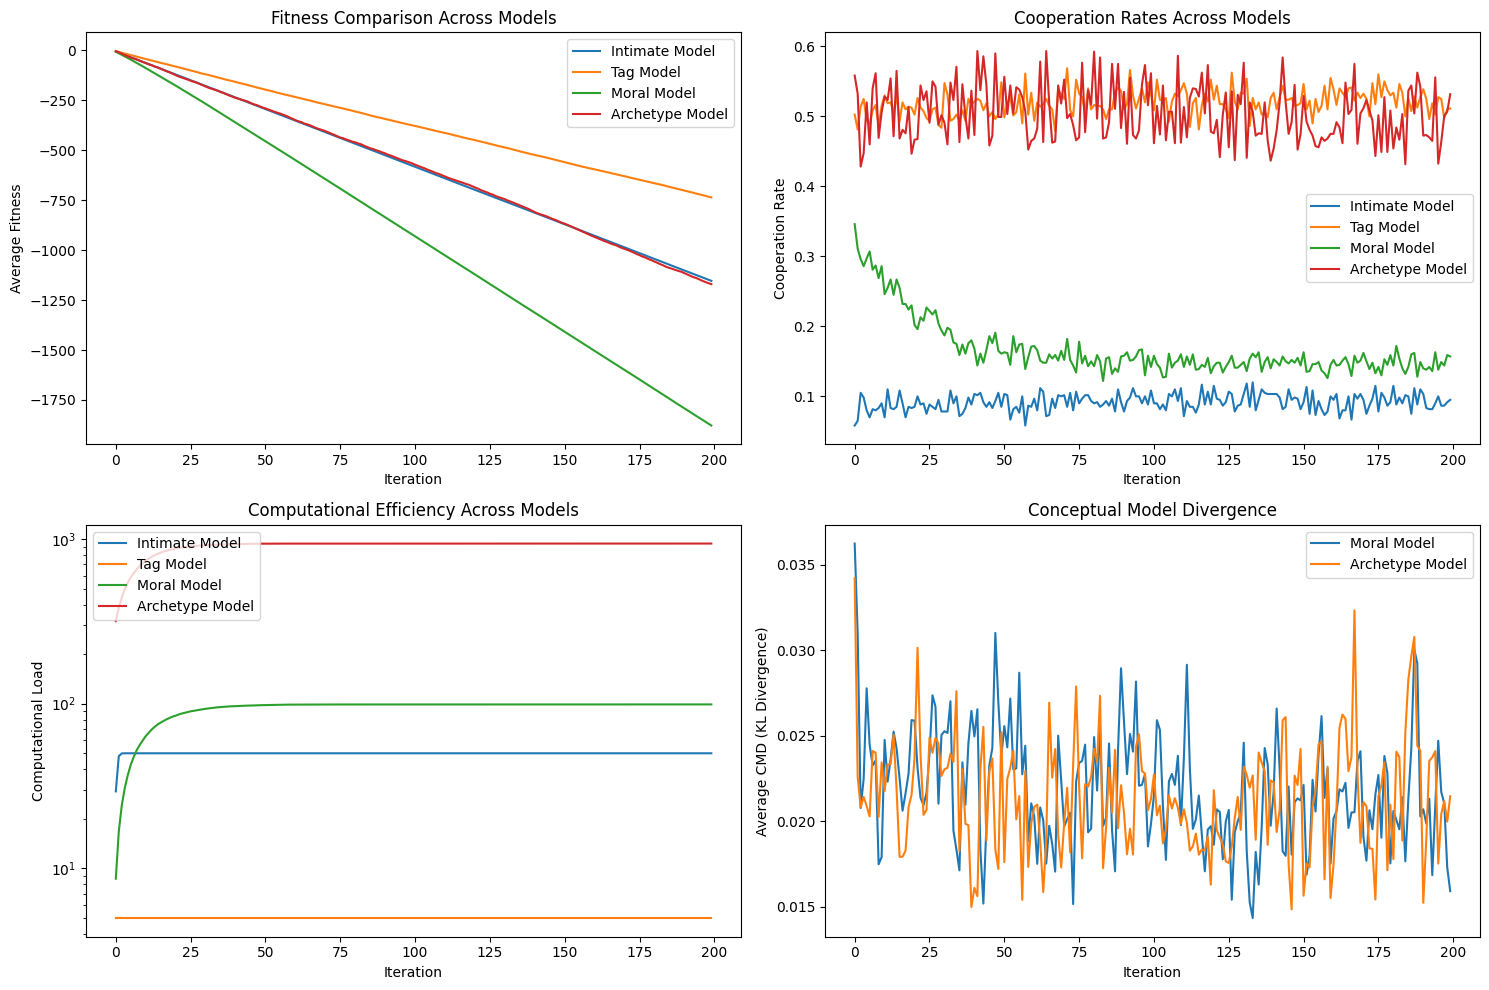

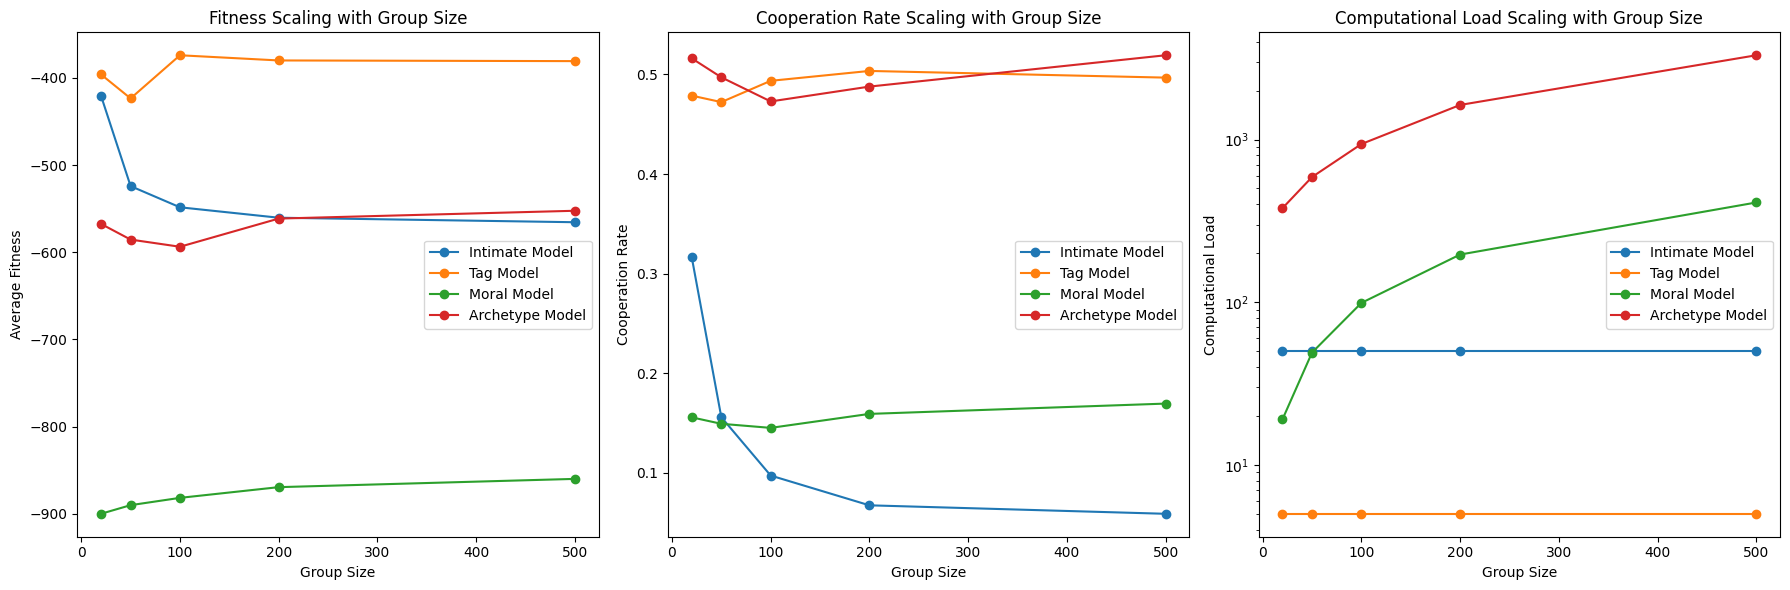

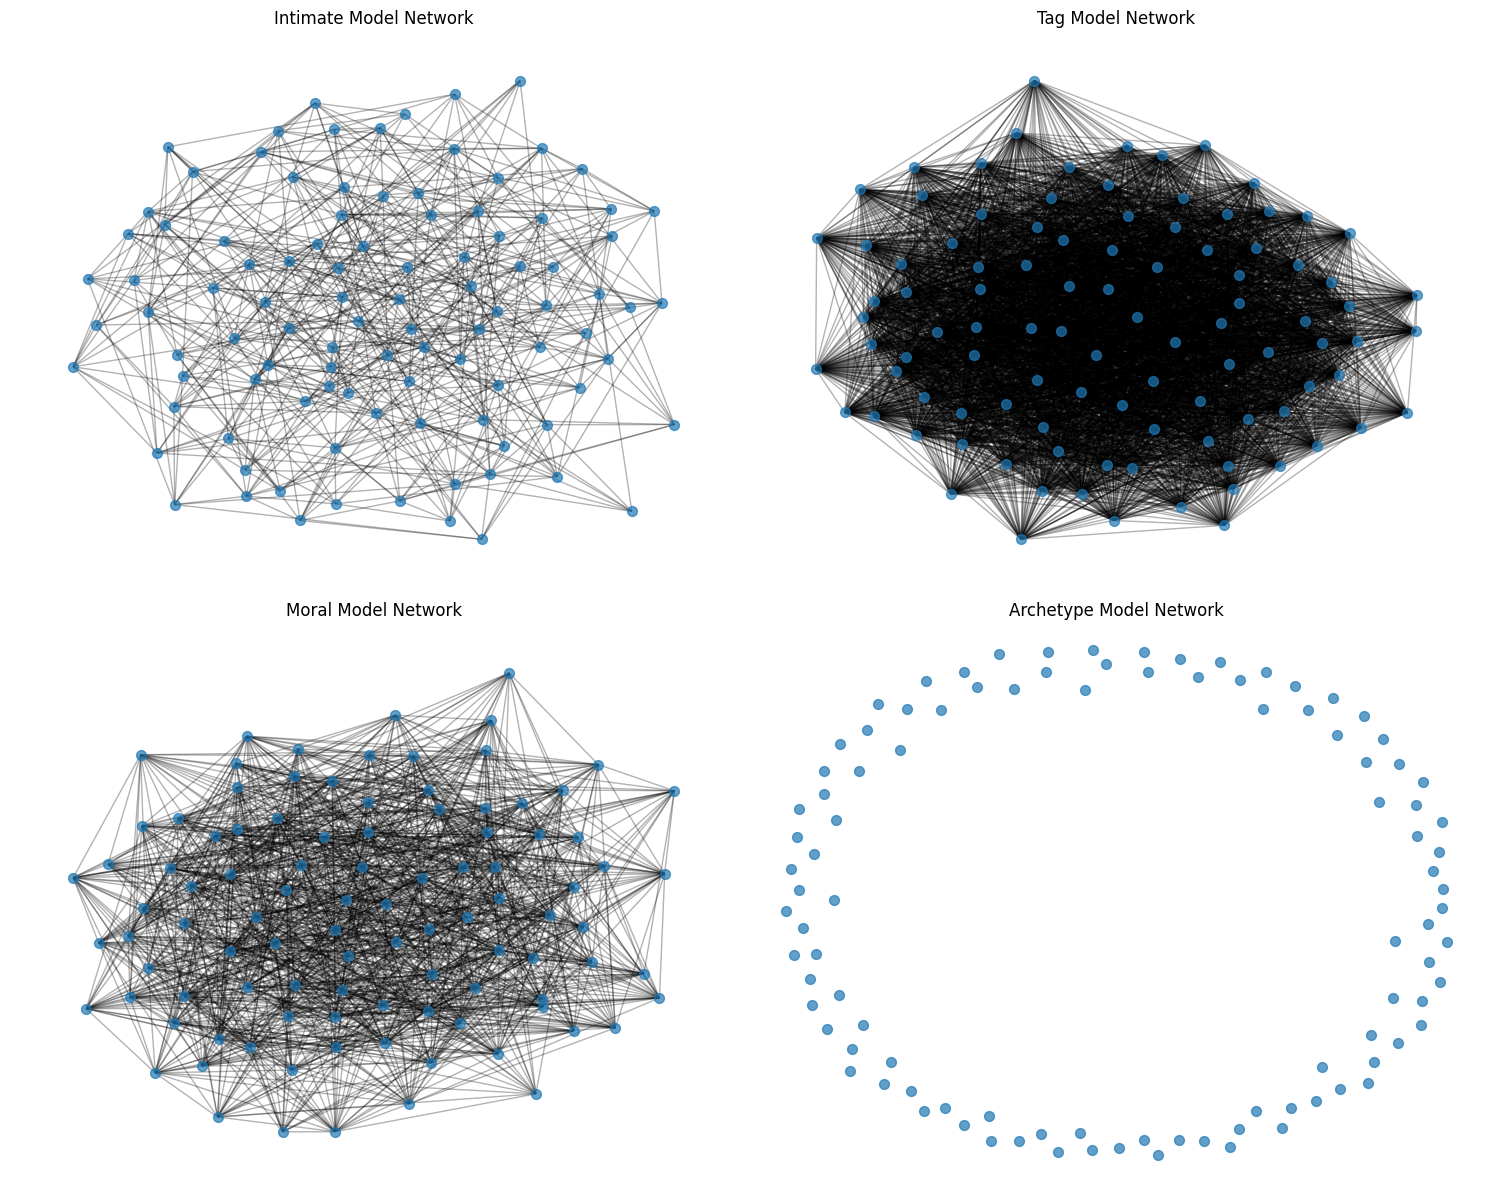

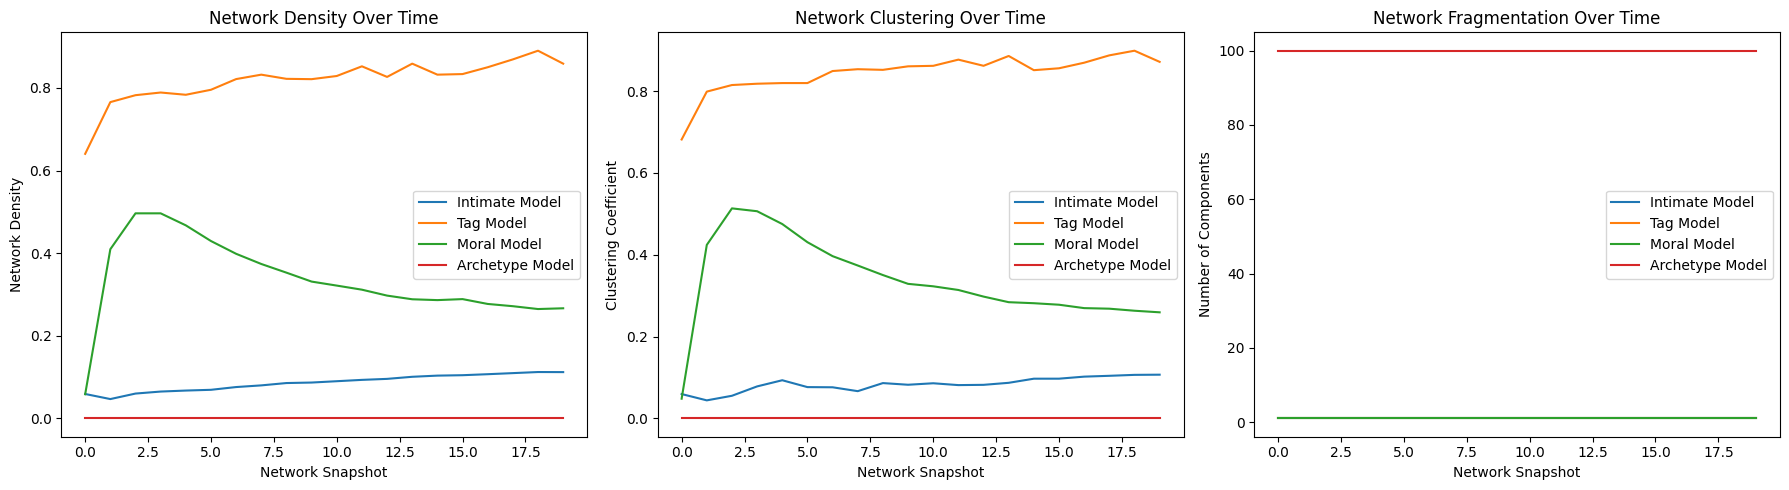

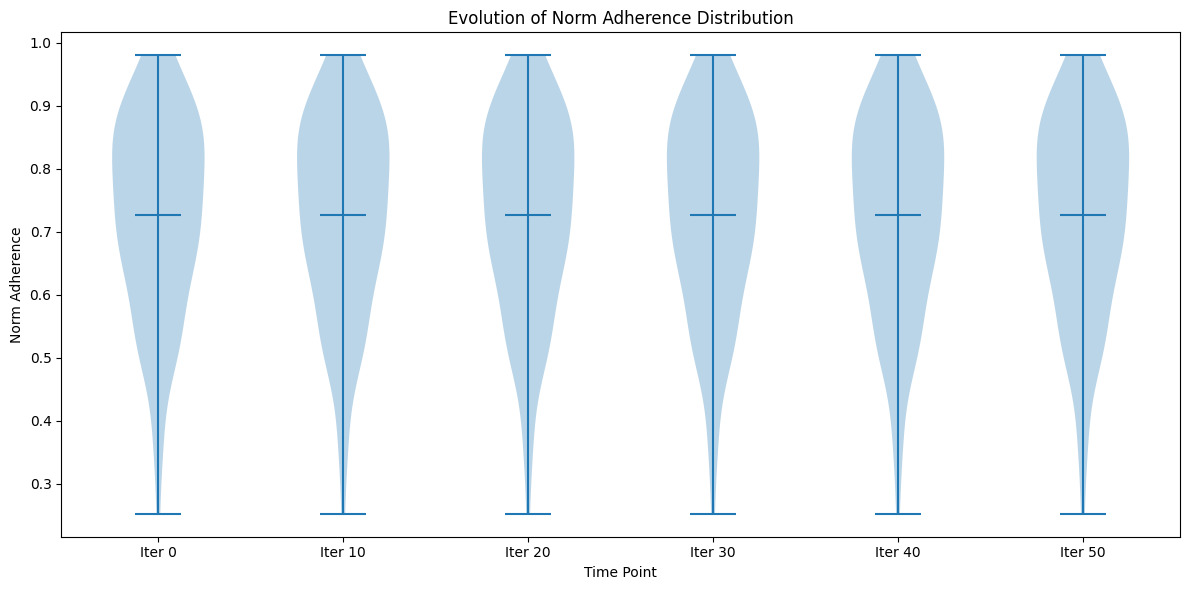

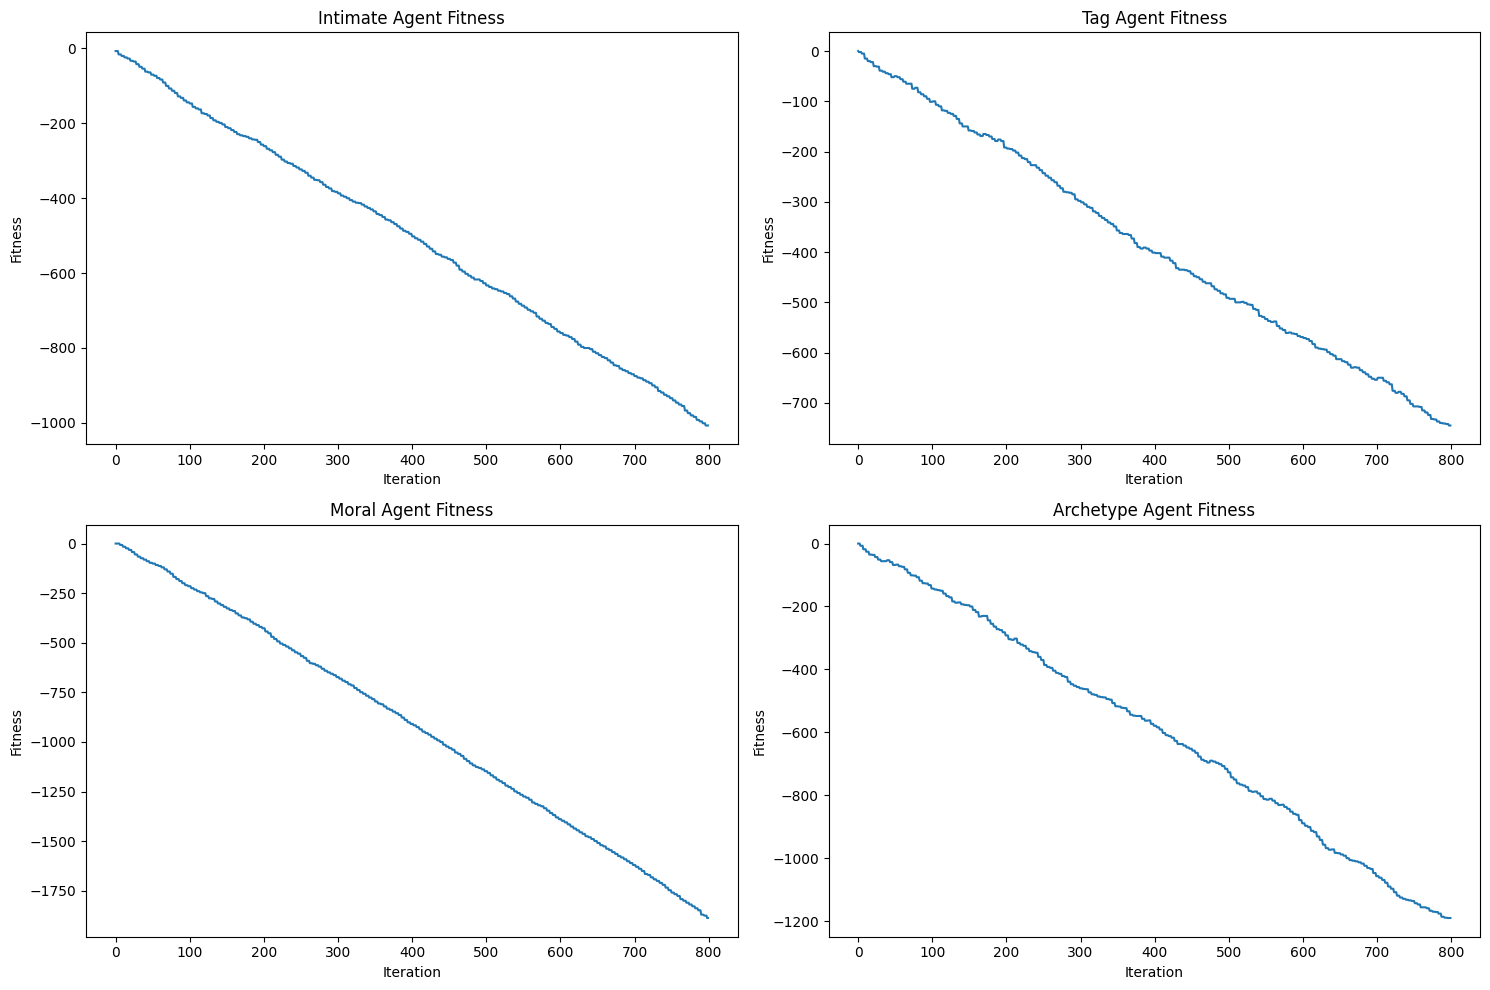

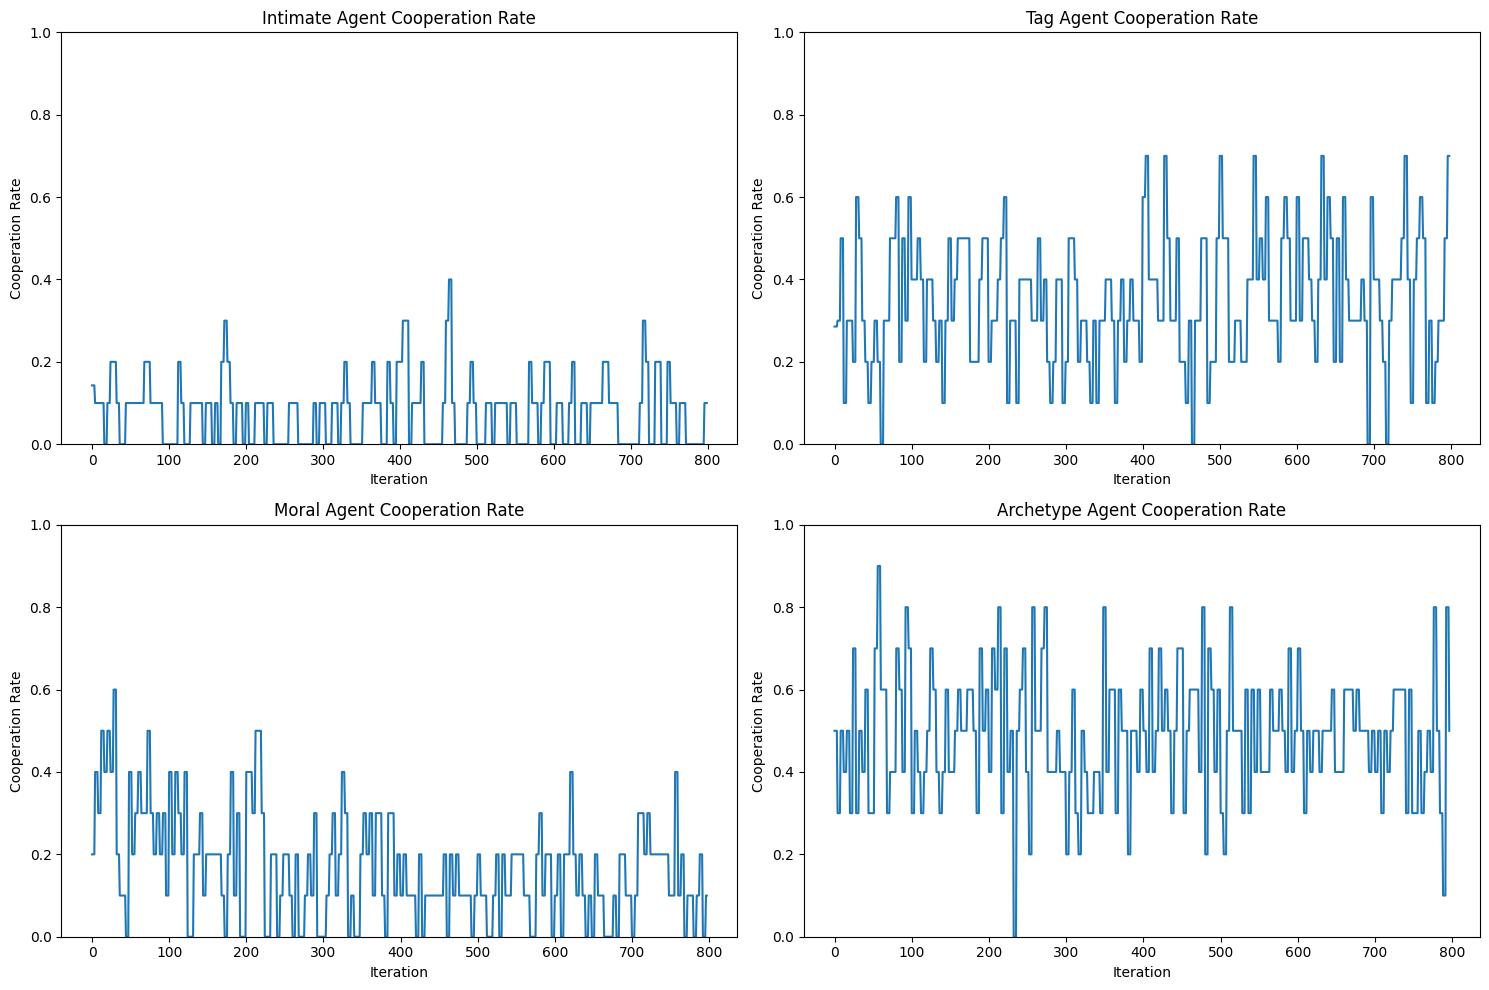

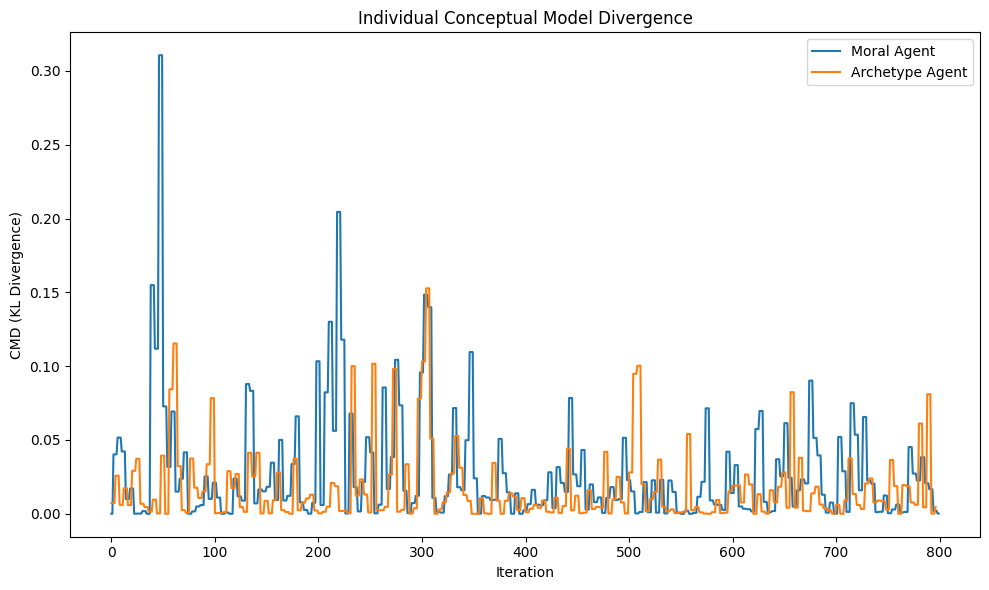

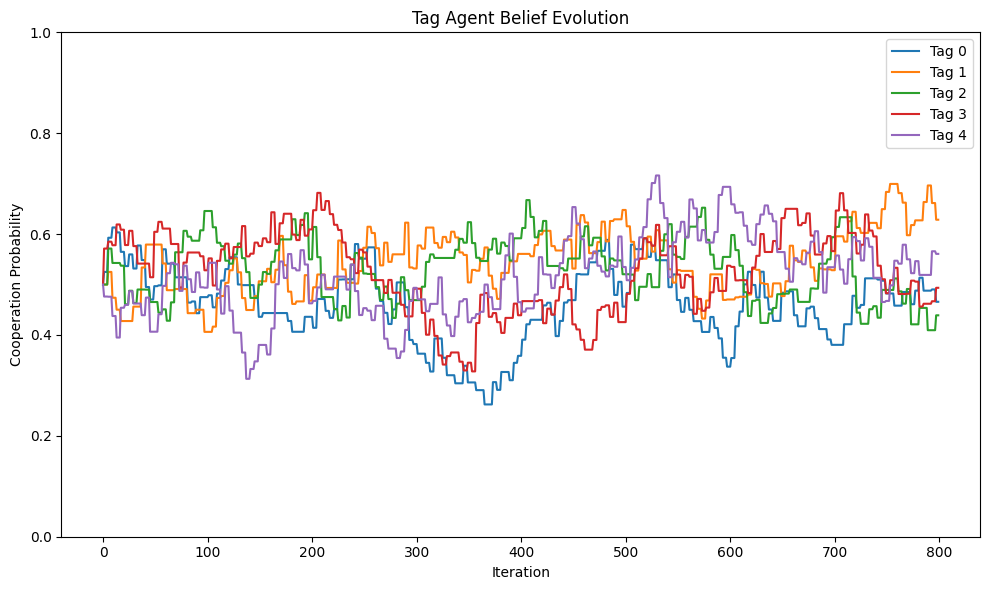

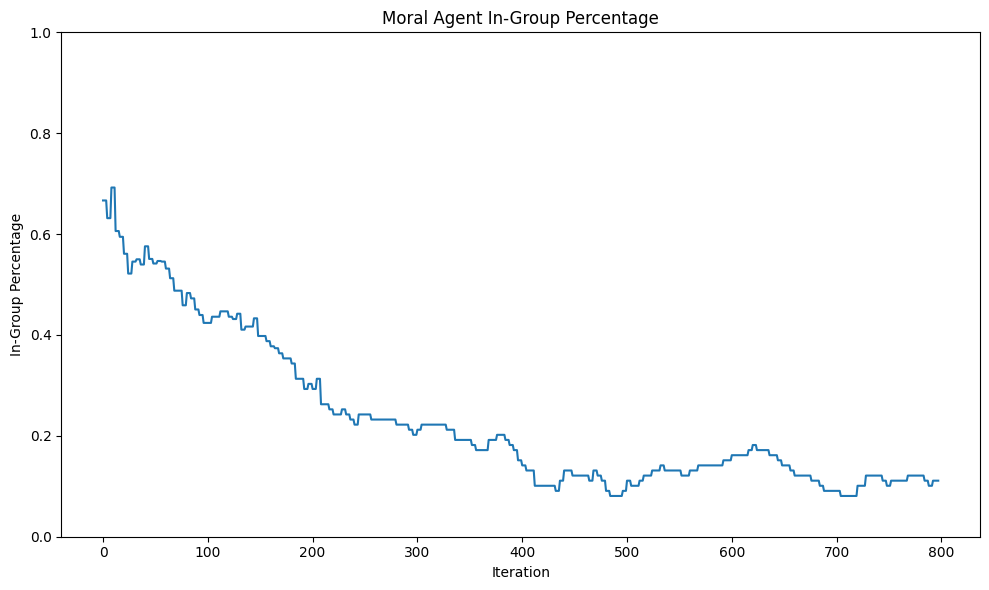

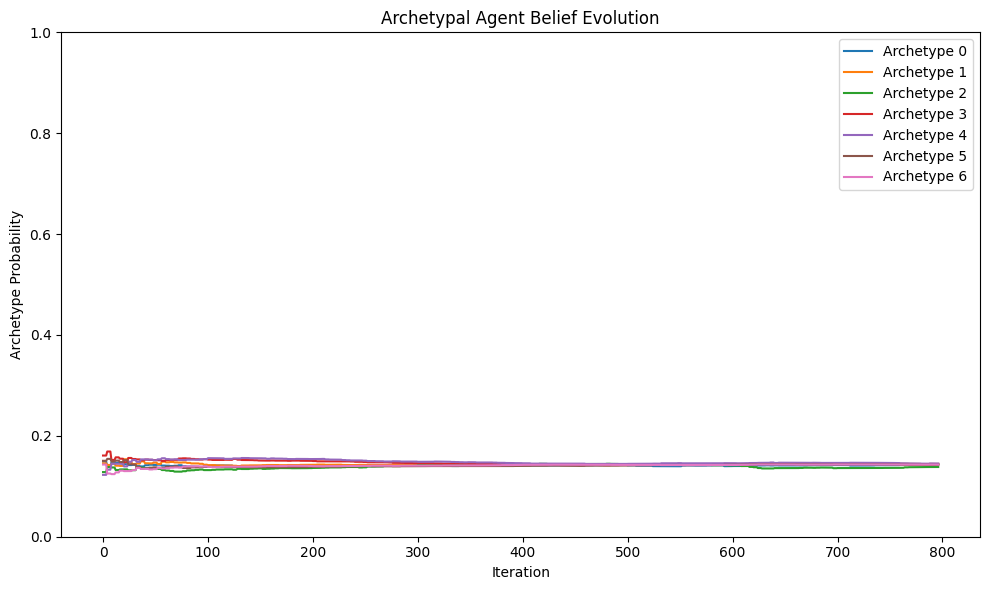

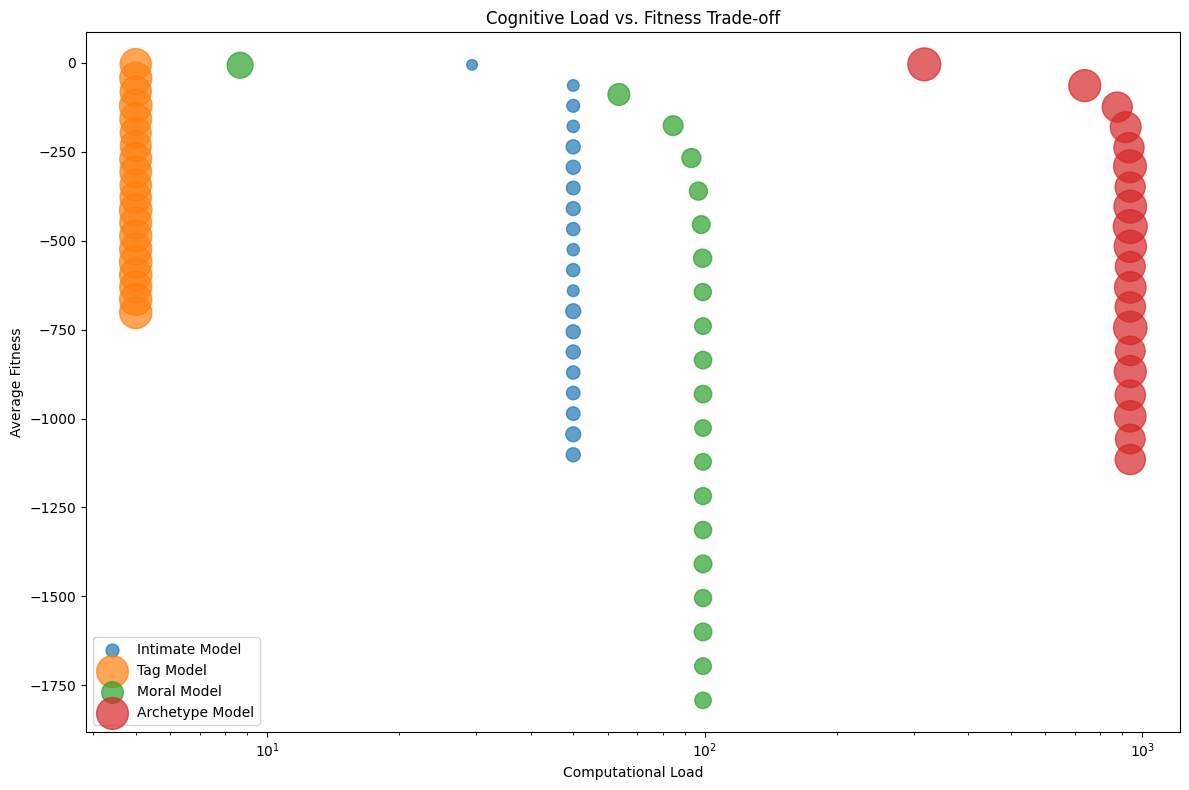

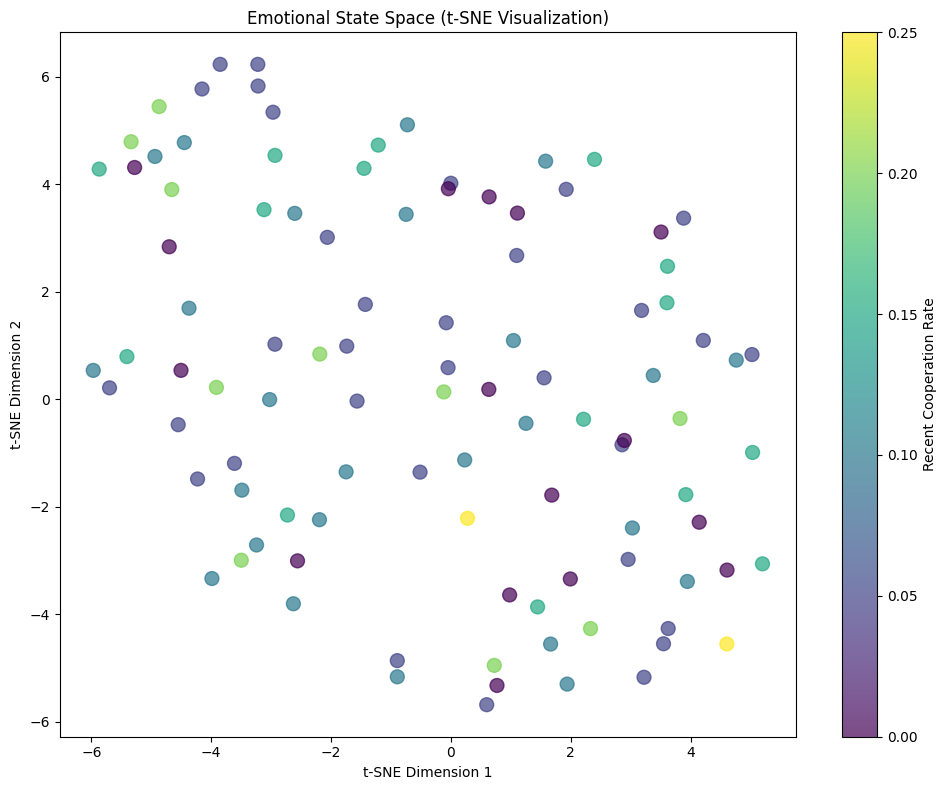

Simulation and visualization complete.


In [14]:
def run_moh_simulation():
    """Run the full MOH simulation and visualize results"""
    # Run basic simulation
    print("Running main MOH simulation...")
    sim = MOHSimulation()
    results = sim.run_simulation()

    # Run group size scaling experiment
    scaling_results = run_group_size_scaling()

    # Create visualizations
    print("Creating visualizations...")

    # Basic results visualization
    visualize_basic_results(results)

    # Scaling results visualization
    visualize_scaling_results(scaling_results)

    # Network analysis
    visualize_networks(results)

    # Norm adherence for moral and archetypal agents
    if sim.agents['moral']:
        adherence_data = analyze_norm_adherence(sim.agents['moral'][:100], 50)
        visualize_norm_adherence(adherence_data)

    # Individual trajectories
    track_individual_trajectories(sim)

    # Cognitive load vs. fitness analysis
    analyze_cognitive_load_fitness_tradeoff(results)

    # Emotion space visualization for intimate agents
    if sim.agents['intimate']:
        create_emotion_space_visualization(sim.agents['intimate'])

    print("Simulation and visualization complete.")

def visualize_basic_results(results):
    """Create basic visualizations of simulation results"""
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Fitness comparison
    for model_type in results:
        axes[0, 0].plot(results[model_type]['avg_fitness'], label=f"{model_type.capitalize()} Model")
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Average Fitness')
    axes[0, 0].set_title('Fitness Comparison Across Models')
    axes[0, 0].legend()

    # Cooperation rates
    for model_type in results:
        axes[0, 1].plot(results[model_type]['cooperation_rate'], label=f"{model_type.capitalize()} Model")
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Cooperation Rate')
    axes[0, 1].set_title('Cooperation Rates Across Models')
    axes[0, 1].legend()

    # Computational load comparison
    for model_type in results:
        axes[1, 0].plot(results[model_type]['computational_load'], label=f"{model_type.capitalize()} Model")
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Computational Load')
    axes[1, 0].set_title('Computational Efficiency Across Models')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()

    # Conceptual Model Divergence
    cmd_models = ['moral', 'archetype']
    for model_type in cmd_models:
        if 'cmd' in results[model_type] and results[model_type]['cmd']:
            axes[1, 1].plot(results[model_type]['cmd'], label=f"{model_type.capitalize()} Model")
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Average CMD (KL Divergence)')
    axes[1, 1].set_title('Conceptual Model Divergence')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('moh_simulation_results.png', dpi=300)
    plt.show()

# Call the main function to run the simulation
if __name__ == "__main__":
    run_moh_simulation()

This final section ties everything together with functions to run the complete simulation and generate all visualizations. The `run_moh_simulation `function orchestrates the entire process, running the main simulation, the group size scaling experiment, and generating all the visualizations. The `visualize_basic_results` function creates the fundamental comparison plot.